# Setup

In [1]:
import os
import re
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import pysam
import anndata as ad
import scanpy as sc

from helpers.helpers import ct_format, get_anndata_coldata

PROJECT_PATH = '/home/fichtner/projects/footprintQTL'
DATA_PATH = '/omics/groups/OE0540/internal/projects/HCA_organoid_2/cemm_sabrina-20Jul2022/'
RNA_AD = 'outputs_allsamples/sabrina_allsamples_rna_final_after_atac.h5ad'

os.chdir(PROJECT_PATH)

### User variables

In [2]:
q_donors = [ 'melw', 'pelm', 'ualf', 'zoxy']
q_ct = ['Glia',  'Midbrain-EN', 'UL-EN']
q_ct = [ct_format(ct) for ct in q_ct]
q_genes = ['CYC1', 'RPL13', 'MEF2C', 'SOX2', 'LHX5']


## Get data and metadata

In [6]:
borgs = ad.read_h5ad(DATA_PATH + RNA_AD, backed='r')

In [41]:
# cells_coldata, ann_idxs, cell_types, samples, donors = get_anndata_coldata(os.path.join(DATA_PATH, RNA_AD))
cells_coldata = borgs.obs[['sample', 'donor', 'celltype_predicted_vertesy']].copy()
cells_coldata['cell_type'] = cells_coldata['celltype_predicted_vertesy']
cells_coldata

,sample,donor,celltype_predicted_vertesy,cell_type
AAACAGCCAACTAACT-1_sSL0082,sSL0082,lexy,immature EN,immature EN
AAACAGCCAGGCAAGC-1_sSL0082,sSL0082,lexy,Glia,Glia
AAACAGCCAGGCCATT-1_sSL0082,sSL0082,laey,UL-EN,UL-EN
AAACAGCCATAGACTT-1_sSL0082,sSL0082,quls,Stressed Prog.,Stressed Prog.
AAACAGCCATTCAGCA-1_sSL0082,sSL0082,laey,Glia,Glia
...,...,...,...,...
TTTGTGGCAACACTTG-1_sSL0182,sSL0182,wibj,DL-EN,DL-EN
TTTGTGGCAATCTCTC-1_sSL0182,sSL0182,zoxy,Interneurons,Interneurons
TTTGTGGCACCACAAC-1_sSL0182,sSL0182,vuna,DL-EN,DL-EN
TTTGTTGGTTTGGGTA-1_sSL0182,sSL0182,vuna,DL-EN,DL-EN


In [42]:
cells_coldata['donor'] = cells_coldata['donor'].astype(str)
cells_coldata['cell_type'] = cells_coldata['cell_type'].apply(lambda x: x.replace(' ', '-').replace('.', ''))
cells_coldata['cell_type'] = cells_coldata['cell_type'].astype(str)
cells_coldata

,sample,donor,celltype_predicted_vertesy,cell_type
AAACAGCCAACTAACT-1_sSL0082,sSL0082,lexy,immature EN,immature-EN
AAACAGCCAGGCAAGC-1_sSL0082,sSL0082,lexy,Glia,Glia
AAACAGCCAGGCCATT-1_sSL0082,sSL0082,laey,UL-EN,UL-EN
AAACAGCCATAGACTT-1_sSL0082,sSL0082,quls,Stressed Prog.,Stressed-Prog
AAACAGCCATTCAGCA-1_sSL0082,sSL0082,laey,Glia,Glia
...,...,...,...,...
TTTGTGGCAACACTTG-1_sSL0182,sSL0182,wibj,DL-EN,DL-EN
TTTGTGGCAATCTCTC-1_sSL0182,sSL0182,zoxy,Interneurons,Interneurons
TTTGTGGCACCACAAC-1_sSL0182,sSL0182,vuna,DL-EN,DL-EN
TTTGTTGGTTTGGGTA-1_sSL0182,sSL0182,vuna,DL-EN,DL-EN


# Covariate UMAPS

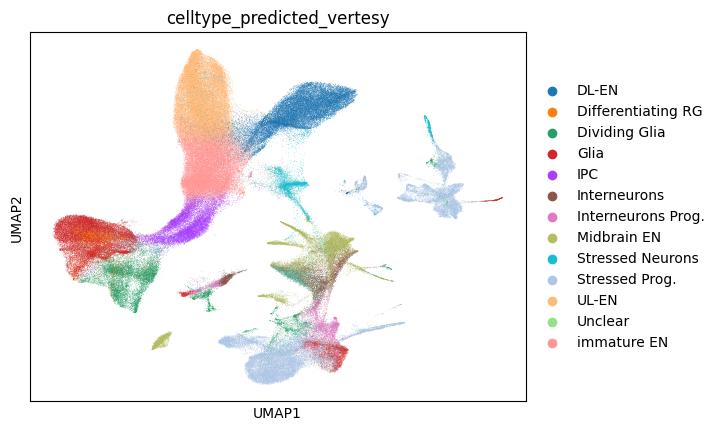

In [9]:
sc.pl.umap(borgs, color='celltype_predicted_vertesy')

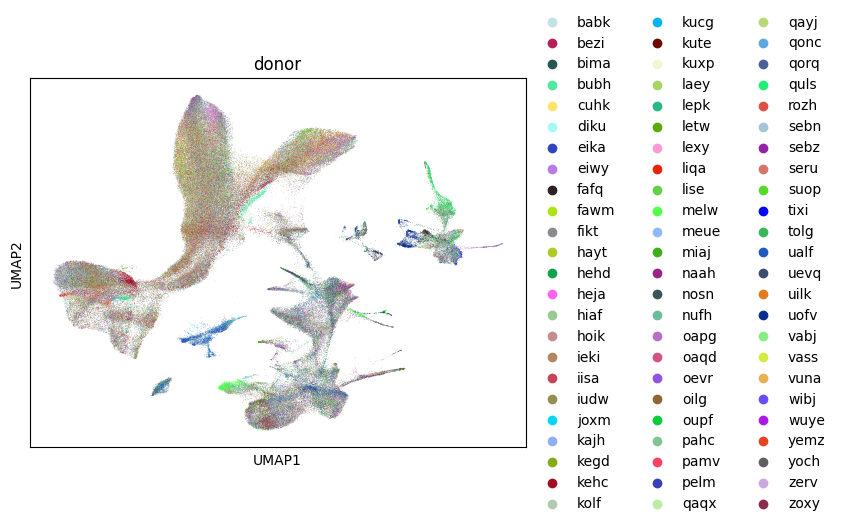

In [10]:
sc.pl.umap(borgs, color='donor')

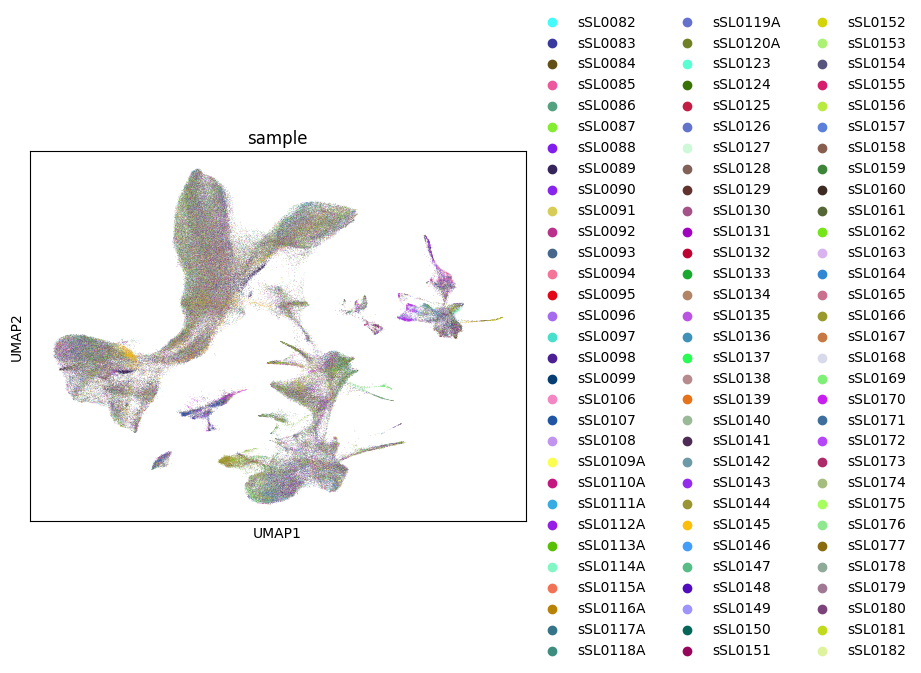

In [11]:
sc.pl.umap(borgs, color='sample')

# Barcode counts per group

In [43]:
grouped = cells_coldata.groupby(['donor', 'cell_type']).size().reset_index(name='n_cells')

grouped['group'] = grouped['donor'] + '_' + grouped['cell_type']

grouped

,donor,cell_type,n_cells,group
0,babk,DL-EN,2,babk_DL-EN
1,babk,Dividing-Glia,52,babk_Dividing-Glia
2,babk,Glia,10,babk_Glia
3,babk,Interneurons,48,babk_Interneurons
4,babk,Interneurons-Prog,32,babk_Interneurons-Prog
...,...,...,...,...
847,zoxy,Interneurons-Prog,78,zoxy_Interneurons-Prog
848,zoxy,Midbrain-EN,275,zoxy_Midbrain-EN
849,zoxy,Stressed-Neurons,122,zoxy_Stressed-Neurons
850,zoxy,Stressed-Prog,1553,zoxy_Stressed-Prog


In [44]:
# N_cells per donor-ct group
subset = cells_coldata[cells_coldata['donor'].isin(q_donors)].copy()
subset['donor'] = subset['donor'].astype(str)

subset = subset[subset['cell_type'].isin(q_ct)].copy()
subset['cell_type'] = subset['cell_type'].astype(str)

subset.groupby(['donor', 'cell_type']).size().reset_index(name='n_cells')

,donor,cell_type,n_cells
0,melw,Glia,9
1,melw,Midbrain-EN,896
2,pelm,Glia,489
3,pelm,Midbrain-EN,825
4,pelm,UL-EN,444
5,ualf,Glia,1120
6,ualf,Midbrain-EN,8
7,ualf,UL-EN,924
8,zoxy,Glia,71
9,zoxy,Midbrain-EN,275


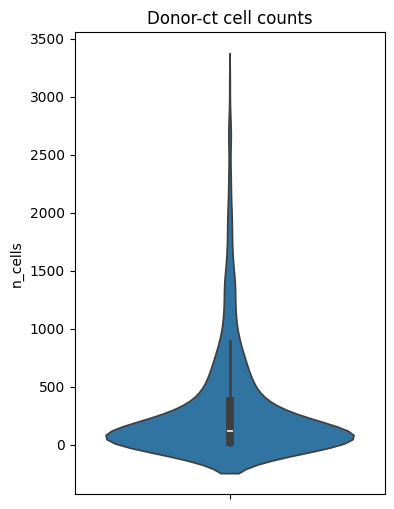

In [45]:
plt.figure(figsize=(4, 6))

sns.violinplot(grouped['n_cells'])

# Add a title and labels
plt.title('Donor-ct cell counts')
plt.xlabel('')

# Show the plot
plt.show()

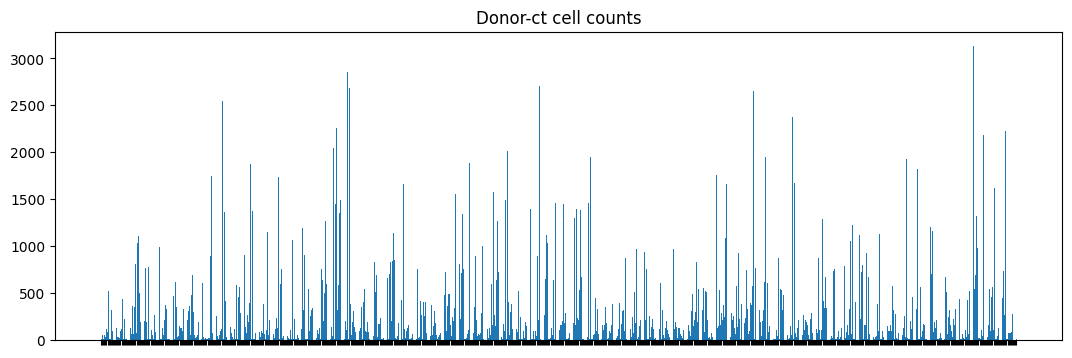

In [46]:
plt.figure(figsize=(13, 4))

plt.bar(grouped['group'], grouped['n_cells'])

# # Add a title and labels
plt.title('Donor-ct cell counts')
plt.xlabel('')
plt.xticks(ticks=plt.xticks()[0], labels=['']*len(grouped['group']))

# Show the plot
plt.show()

# Expression

## Query groups

In [48]:
borgsX_subset = borgs[cells_coldata['donor'].isin(q_donors) & cells_coldata['cell_type'].isin(q_ct)].to_df()
borgsX_aggregated = borgsX_subset.join(cells_coldata.loc[:, ['donor', 'cell_type']], how='inner')
borgsX_aggregatedd = borgsX_aggregated.groupby(['donor', 'cell_type']).sum()

In [49]:
borgsX_aggregatedd[q_genes].astype(int)

CYC1  RPL13  MEF2C  SOX2  LHX5
donor cell_type                                  
melw  Glia            3     13      2     8     0
      Midbrain-EN   474   1233    169   154   214
pelm  Glia          178    858     91   960     0
      Midbrain-EN   319    653    194   132   337
      UL-EN         220    696    903    15     0
ualf  Glia          336   2086    190  1281     0
      Midbrain-EN     5      6      1     4     0
      UL-EN         287   1180   2364    99     0
zoxy  Glia           20     92      5   139     0
      Midbrain-EN    90    249     34    64   115

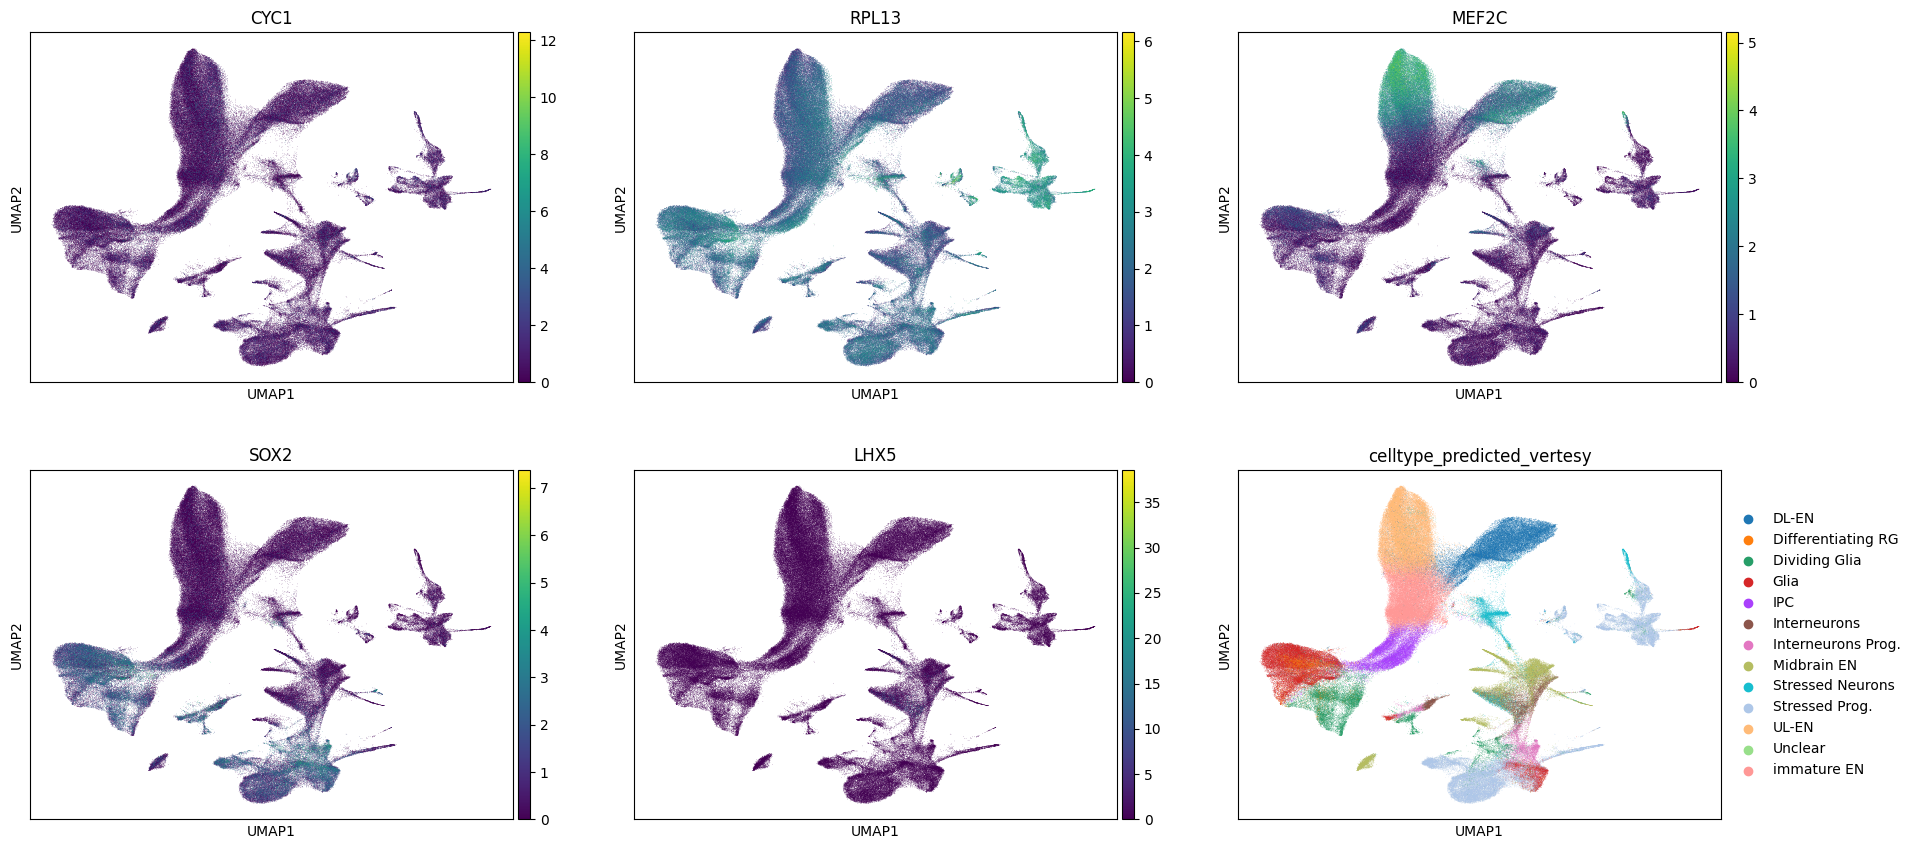

In [50]:
sc.pl.umap(borgs, color=q_genes + ['celltype_predicted_vertesy'], ncols=3)

## Cell lineage markers

In [ ]:
#import re
#[i for i in borgs.var.index if re.compile(r'NeuroD', re.IGNORECASE).search(i)]

In [83]:
lineage_genes = [
    'SOX2', # Pluripotency
    'SLC1A3', # ='GLAST', # Astroglia
    'FABP7', # 'BLBP',
    'NCAM1', # Schwann cells
    'NCAM2',
    'GFAP',
    'MBP', # Maturation
    'PAX6', # Intermediate progenitors
    'NEUROD1', # ='ND1' Neuronal fate determinant
    'ENO2', # = 'NSE' Neurons
    'MAP2',
    'ITGAM', # = 'CD11b' Microglia
]

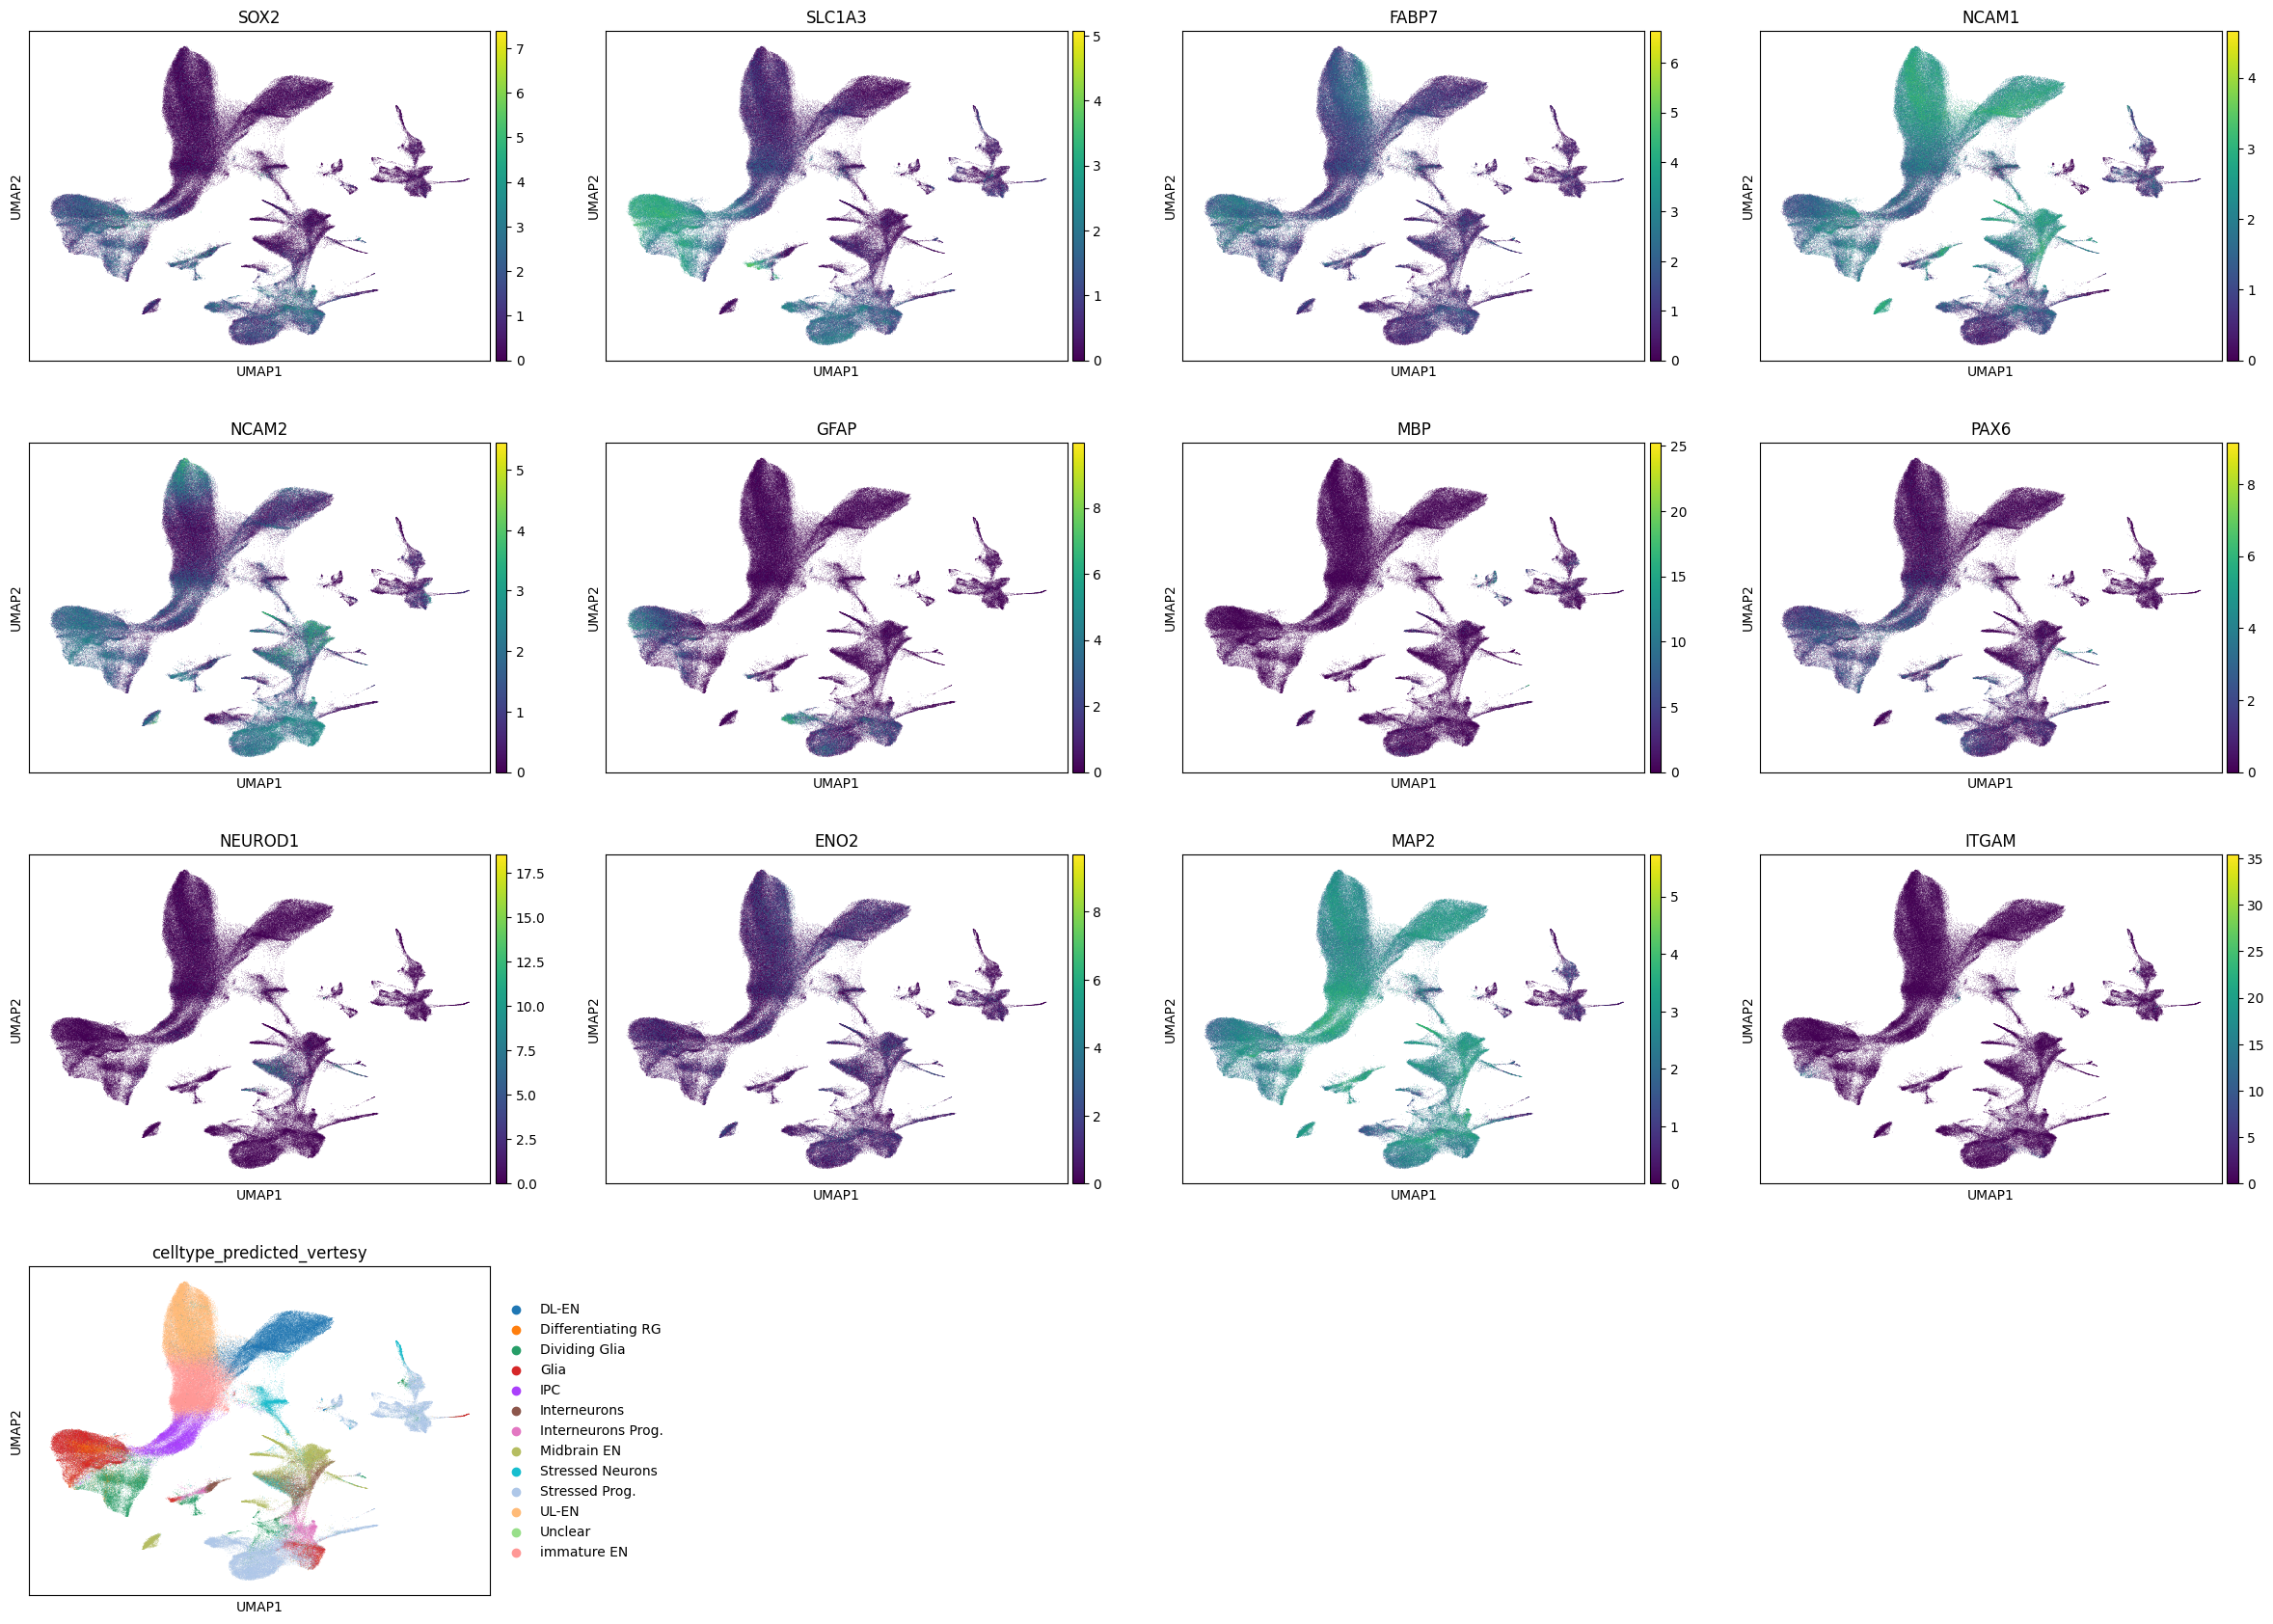

In [85]:
sc.pl.umap(borgs, color=lineage_genes + ['celltype_predicted_vertesy'])#, ncols=3)